# Import Packages

In [1]:
import pandas as pd
import pyaudio
import numpy as np
from IPython import display
import os
from sklearn.preprocessing import normalize
import datetime

In [2]:
from pynput import keyboard
import wave

In [3]:
# Should see a default device, otherwise will get an error below
pa = pyaudio.PyAudio()
pa.get_default_input_device_info()

{'defaultHighInputLatency': 0.18,
 'defaultHighOutputLatency': 0.18,
 'defaultLowInputLatency': 0.09,
 'defaultLowOutputLatency': 0.09,
 'defaultSampleRate': 44100.0,
 'hostApi': 0,
 'index': 1,
 'maxInputChannels': 2,
 'maxOutputChannels': 0,
 'name': 'Microphone (Logitech USB Microp',
 'structVersion': 2}

# Testing

In [12]:
# # I want to record for approximately 200ms for each keypress. This recording should center on the press event.
# # <---200ms---> KeyPress <---100ms--->
# chunk = 1024
# f = pyaudio.paInt16 # Format
# rate = 44100
# delta_ms = 25 # Stream read size in milliseconds
# full_record_ms = 200 # Key press audio recording length in milliseconds
# post_press_ms = 100 # Recording time after key press in milliseconds


# row_size = int(rate / chunk * delta_ms * (1/1000))

# p = pyaudio.PyAudio()
# stream = p.open(format = f, channels = 1, rate = rate, input = True, frames_per_buffer = chunk)

# running = True

# frames = []
# df_list = []

In [6]:
# import threading
# from time import sleep

In [7]:
# import queue
# q = queue.Queue() # Use Queue as FIFO for recorded frames

In [9]:
# def worker():
#     while running:
#         data = stream.read(chunk * row_size) # Raw data in byte format
#         q.put(data)

#         if q.qsize() > round(full_record_ms/delta_ms):
#             q.get()
#         #data_int = np.frombuffer(data, dtype=np.int16) # convert to int16

#     # Create dictionary for each sample and add to list (used later to )
#     #sample = [{'key': key, 'data': data_int, 'raw': data, 'timestamp': datetime.datetime.utcnow()}]
#     #self.df_list.extend(sample)
    
#     stream.stop_stream()
#     stream.close()
#     p.terminate()
    
#     return

In [11]:
# def on_press(key):
#     print(key)
#     # Escape Pressed
#     if key == keyboard.Key.esc:
#         running = False
#         return False
#     else:
#         sleep(post_press_ms/1000)
#         frames = list(q.queue)
#         waveFile = wave.open("test.wav", 'wb')
#         waveFile.setnchannels(1)
#         waveFile.setsampwidth(p.get_sample_size(f))
#         waveFile.setframerate(rate)
#         waveFile.writeframes(b''.join(frames))
#         waveFile.close() 

# threads = []
# t = threading.Thread(target=worker)
# threads.append(t)
# t.start()

# with keyboard.Listener(on_press=on_press) as listener:
#     listener.join()

Key.space
Key.space
Key.esc


### On keypress, record microphone
### On keyrelease, save data

In [57]:
import threading
from time import sleep
import queue

class KeyAudio(object):
    def __init__(self):
        print("Instantiating...")
        
        # I want to record for approximately 300ms for each keypress. This recording should center on the press event.
        # <---150ms---> KeyPress <---150ms--->
        
        self.chunk = 1024
        self.format = pyaudio.paInt16
        self.channels = 1
        self.rate = 44100
        self.delta_ms = 25 # Stream read size in milliseconds
        self.full_record_ms = 250 # Key press audio recording length in milliseconds
        self.post_press_ms = 150 # Recording time after key press in milliseconds
        
        self.row_size = int(self.rate / self.chunk * self.delta_ms * (1/1000))
        
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(format = self.format, channels = self.channels, rate = self.rate, input = True, frames_per_buffer = self.chunk)
        
        self.running = False # Keyboard and Audio Log started flag
        
        self.frames = [] # A list of delta_ms raw byte samples
        self.df_list = [] # Holds list of dictionaries until user saves as dataframe
        self.q = queue.Queue() # Use Queue as FIFO for recorded frames
        
        self.key_cnt = 0 # Track the number of recorded keypresses for this session
    
    # Start Listening for Keyboard Presses and recording Audio
    def startListener(self):
        print("Starting listener...")
        self.running = True
        
        # Record microphone in separate thread
        threads = []
        t = threading.Thread(target=self.log)
        threads.append(t)
        t.start()

        with keyboard.Listener(on_press=self.on_press) as listener:
            listener.join()
      
    # Keyboard Press
    def on_press(self, key):
        print(key)
        
        # Escape Pressed
        if key == keyboard.Key.esc:
            self.running = False
            return False # Stop Key Listener
        else:
            sleep(self.post_press_ms/1000) # Keep recording audio for some delta defined after the key is pressed
            
            if self.q.qsize() != round(self.full_record_ms/self.delta_ms):
                print("Error: Incorrect queue size: {}".format(self.q.qsize()))
                return
            
            self.frames = list(self.q.queue)
            frame_bytes = bytearray([byte for row in self.frames for byte in row])
            frames_int = np.frombuffer(frame_bytes, dtype=np.int16) # convert to int16
            
            # Create dictionary for each sample and append to list (used later to create dataframe)
            record_sample = [{'key': key, 'data': frames_int, 'raw': frame_bytes, 'timestamp': datetime.datetime.utcnow()}]
            self.df_list.extend(record_sample)
            
            if self.key_cnt % 50 == 49:
                print("Saving dataframe. Session key count: {}".format(self.key_cnt))
                self.save_dataframe()
            
            self.key_cnt += 1 # New keypress recorded
            
    def log(self):
        while self.running:
            data = self.stream.read(self.chunk * self.row_size) # Raw data in byte format
            self.q.put(data)

            if self.q.qsize() > round(self.full_record_ms/self.delta_ms):
                self.q.get()

        # When run complete, stop stream
        self.stream.stop_stream()
        self.stream.close()
        self.p.terminate()
        
    def get_dataframe(self):
        return self.df_list
    
    def save_data_as_wav(self, data, filename="file.wav"):
        WAVE_OUTPUT_FILENAME = filename
        waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb') # 'wb' write only mode
        waveFile.setnchannels(self.channels)
        waveFile.setsampwidth(self.p.get_sample_size(self.format))
        waveFile.setframerate(self.rate)
        waveFile.writeframes(data)
        waveFile.close()
        
    def save_dataframe(self, filename='DataSet/data.pkl'):
        df = pd.DataFrame.from_records(self.get_dataframe())
        
        # Get existing data and combine with new data
        if os.path.isfile(filename):
            df_saved = pd.read_pickle(filename)
            df = df_saved.append(df, ignore_index=True)
            
        # Save to pickle file
        df.to_pickle(filename)

# Data Sampling
#### Hit Esc to stop sampling

In [58]:
key = KeyAudio()
key.startListener()

Instantiating...
Starting listener...
'T'
'H'
'I'
'S'
Key.space
'I'
'S'
Key.space
'A'
Key.space
'T'
'E'
'S'
'T'
Key.space
'O'
'F'
Key.space
'T'
'H'
'E'
Key.space
'E'
'M'
'E'
'R'
'G'
'E'
'N'
'C'
'Y'
Key.space
'B'
'R'
'O'
'A'
'D'
'C'
'A'
'S'
'T'
Key.space
'S'
'Y'
'S'
'T'
'E'
'M'
'>'
Key.space
Saving dataframe. Session key count: 49
'N'
'O'
'W'
Key.space
'I'
Key.space
'A'
'M'
Key.space
'J'
'U'
'S'
'T'
Key.space
'P'
'R'
'E'
'S'
'S'
'I'
'N'
'G'
Key.space
'K'
'E'
'Y'
'S'
Key.space
'F'
'O'
'R'
Key.space
'A'
Key.space
'W'
'H'
'I'
'L'
'E'
Key.space
'A'
'N'
'D'
Key.space
'N'
'O'
'W'
Key.space
'I'
'M'
Saving dataframe. Session key count: 99
Key.space
'G'
'O'
'I'
'N'
'G'
Key.space
'T'
'O'
Key.space
'P'
'R'
'E'
'S'
'S'
Key.space
'S'
'O'
'M'
'E'
Key.space
'M'
'O'
'R'
'E'
Key.esc


# Read saved dataframe

In [59]:
# Read saved list of data from object into a dataframe
df = pd.read_pickle('DataSet/data.pkl')
print(len(df))
df.head()

150


,data,key,raw,timestamp
0,"[5, 13, 28, 15, 24, 27, 16, 31, 42, -6, 17, 33...",'T',"[5, 0, 13, 0, 28, 0, 15, 0, 24, 0, 27, 0, 16, ...",2018-07-08 15:15:35.150976
1,"[13, -6, -21, -7, -17, -10, 5, 6, 3, 8, -3, -1...",'H',"[13, 0, 250, 255, 235, 255, 249, 255, 239, 255...",2018-07-08 15:15:36.197419
2,"[-9, -4, -20, -25, -19, -18, -29, -32, -23, -1...",'I',"[247, 255, 252, 255, 236, 255, 231, 255, 237, ...",2018-07-08 15:15:37.077786
3,"[-46, -53, -45, -29, -20, -36, -22, -36, -32, ...",'S',"[210, 255, 203, 255, 211, 255, 227, 255, 236, ...",2018-07-08 15:15:37.801130
4,"[46, 54, 47, 42, 39, 55, 59, 54, 62, 61, 58, 7...",Key.space,"[46, 0, 54, 0, 47, 0, 42, 0, 39, 0, 55, 0, 59,...",2018-07-08 15:15:38.692581


# Plot Data Row

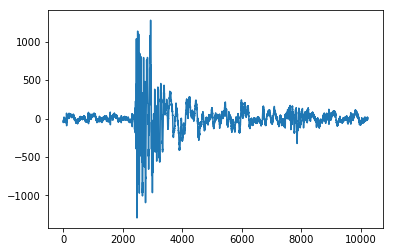

In [60]:
import matplotlib.pyplot as plt
plt.plot(df['data'][3])
plt.show()

# Save as WAV

In [102]:
key.save_data_as_wav(df['data'][0])